In [1]:
# This can read data from PEER, but file should be arranged 1,2,3,4.AT2 and can perform Response Spectrum Analysis 

In [2]:
import pandas as pd
import numpy as np
#import geopandas as gdp
#from shapely.geometry import line
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.widgets import Cursor, Button
from collections import Counter         
from matplotlib import pyplot as plt

In [3]:
# EL- CENTRO DATA

In [4]:
deviation = 1
spectra_type = "Normalized Pseudo-Velocity"
image_resolution = 500

# Time for Response Spectra
delta_period = 0.02
max_period = 50 # in sec
steps = int(max_period/delta_period)
damping = 5/100   # in percentage 

In [5]:
"""
@author: Daniel Hutabarat - UC Berkeley, 2017
"""
import numpy as np
import os
import matplotlib.pyplot as plt

def processNGAfile(filepath, scalefactor=None):
    '''
    This function process acceleration history for NGA data file (.AT2 format)
    to a single column value and return the total number of data points and 
    time iterval of the recording.
    Parameters:
    ------------
    filepath : string (location and name of the file)
    scalefactor : float (Optional) - multiplier factor that is applied to each
                  component in acceleration array.
    
    Output:
    ------------
    desc: Description of the earthquake (e.g., name, year, etc)
    npts: total number of recorded points (acceleration data)
    dt: time interval of recorded points
    time: array (n x 1) - time array, same length with npts
    inp_acc: array (n x 1) - acceleration array, same length with time
             unit usually in (g) unless stated as other.
    
    Example: (plot time vs acceleration)
    filepath = os.path.join(os.getcwd(),'motion_1')
    desc, npts, dt, time, inp_acc = processNGAfile (filepath)
    plt.plot(time,inp_acc)
        
    '''    
    try:
        if not scalefactor:
            scalefactor = 1.0
        with open(filepath,'r') as f:
            content = f.readlines()
        counter = 0
        desc, row4Val, acc_data = "","",[]
        for x in content:
            if counter == 1:
                desc = x
            elif counter == 3:
                row4Val = x
                if row4Val[0][0] == 'N':
                    val = row4Val.split()
                    npts = float(val[(val.index('NPTS='))+1].rstrip(','))
                    dt = float(val[(val.index('DT='))+1])
                else:
                    val = row4Val.split()
                    npts = float(val[0])
                    dt = float(val[1])
            elif counter > 3:
                data = str(x).split()
                for value in data:
                    a = float(value) * scalefactor
                    acc_data.append(a)
                inp_acc = np.asarray(acc_data)
                time = []
                for i in range (0,len(acc_data)):
                    t = i * dt
                    time.append(t)
            counter = counter + 1
        return desc, npts, dt, time, inp_acc
    except IOError:
        print("processMotion FAILED!: File is not in the directory")
#accfile ='E:/OneDrive - University of Otago/DATA_&_ANALYSIS/SEISMOTECTONICS_ZONES_NZ(2010)_25_SEP_021/ANALYSIS/Response_Spectra/PEERNGARecords_Unscaled/RSN740_LOMAP_ADL250.DT2'
#desc,npts,dt,time,inp_acc = processNGAfile(accfile)


t: 100%|████████████████████████████████████████████████████████████████████████████| 60/60 [7:12:49<00:00, 432.83s/it]


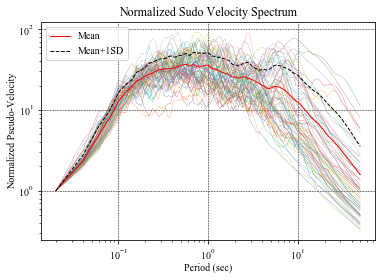

In [6]:
initial_num = 1
final_num = 60
#T = np.zeros((1000,final_num))
df_disp = pd.DataFrame()
df_vel = pd.DataFrame()
df_acc = pd.DataFrame()


df_disp = pd.DataFrame(index=range(steps),columns=range(0))
df_vel = pd.DataFrame(index=range(steps),columns=range(0))
df_acc = pd.DataFrame(index=range(steps),columns=range(0))
df_disp_norm = pd.DataFrame(index=range(steps),columns=range(0))
df_vel_norm = pd.DataFrame(index=range(steps),columns=range(0))
df_acc_norm = pd.DataFrame(index=range(steps),columns=range(0))


from matplotlib.font_manager import FontProperties
plt.rcParams["font.family"] = "Times New Roman"    # Font type for all 

plt.rc('grid', linestyle="--", color='black',linewidth=0.5)    # This is used to draw internal grid line 


fig = plt.figure()                           
#fig = plt.figure(figsize=(fig_size_x, fig_size_y))                       # size of ffigure
ax = fig.gca()
plt.title("Normalized Sudo Velocity Spectrum")      
plt.xlabel("Period (sec)",labelpad=1,fontsize=10, fontweight='bold')                               
plt.ylabel("%s"%spectra_type,labelpad=1,fontsize=10, fontweight='bold')                                              
plt.grid()                                                                # X-AXIS lower & upper limit
#plt.xlim(x_lower_limit,x_upper_limit)                                     # Y-AXIS Lower & Upper Limit
#plt.ylim(y_lower_limit, y_upper_limit)                                    # 
#resolution_value = image_resolution  

from tqdm import tqdm

pbar = tqdm(desc='t',total=final_num)

while initial_num <= final_num   :
    
    accfile ='E:/Fast_Track_PSHA/Design_Response-Spectra/Python_Program/EW-NS/%d.AT2'%initial_num
    desc,npts,dt,time,inp_acc = processNGAfile(accfile)
    
    t = pd.Series(time)
    E = inp_acc
    

# Import xls file    
#    el = pd.read_excel('ELC%d.xls'%initial_num)
#    t = el.iloc[:,0]
#    E = np.zeros((len(el.iloc[:,1]),1))
#    E[:,0] =el.iloc[:,1]
    
    
# INPUT DATA
    xi = 0.05
    m = 1
    dt = t[1] - t[0]
    T = np.zeros((steps,1))
    T[:,0] = np.linspace(delta_period,max_period,steps)[:]
    omega_n = 2*np.pi/T
    k = m*omega_n*omega_n
    
#SOLUTION
    import numpy as np
    import scipy.linalg as la
    
    
    u0 = np.zeros((len(omega_n),1))
    for j in range(len(omega_n)):
        wn = omega_n[j,0]
        A = np.array([[0,1],[-wn**2, -2*xi*wn]])
        D, V = la.eig(A)
        ep = np.array([[np.exp(D[0]*dt),0],[0,np.exp(D[1]*dt)]])
        Ad = V.dot(ep).dot(np.linalg.inv(V))
        Bd = np.linalg.inv(A).dot(Ad-np.eye((len(A))))
        z = [[0],[0]]
        d = np.zeros((len(E),1))
        v = np.zeros((len(E),1))
    
        for i in range(len(E)):
            z = np.real(Ad).dot(z) + np.real(Bd).dot([[0],[-E[i]]])    #[-E[i]*386.09]])
            d[i] = z[0,0]
            v[i] = z[1,0]
        u0[j] = max(abs(d))
        
        #plt.plot(T,u0)
        #plt.show()
    
    # Response Spectral
    u0
    
    V = omega_n*u0
    A = omega_n*omega_n*u0
    
#    v = V.tolist()
    
    df_disp['data_%d'%initial_num] = u0
    df_disp_norm['data_%d'%initial_num] = df_disp['data_%d'%initial_num]/df_disp['data_%d'%initial_num].values[0]
    
    
    #df_disp["mean"] = df_disp["mean"]/df_disp["mean"].values[0]
    df_vel['data_%d'%initial_num] = V
    df_vel_norm['data_%d'%initial_num] = df_vel['data_%d'%initial_num]/df_vel['data_%d'%initial_num].values[0]
    
    
    df_acc['data_%d'%initial_num] = A
    df_acc_norm['data_%d'%initial_num] = df_acc['data_%d'%initial_num]/df_acc['data_%d'%initial_num].values[0]
    
    #Vel = V.tolist()
    #vel.append(Vel)
    
    #Acc =A.tolist()
    #acc.append(Acc)
    
    #Disp = u0.tolist()
    #disp.append(Disp)
    V1 = df_vel_norm['data_%d'%initial_num]
    
    

    plt.loglog(T,V1,linewidth=0.25,label='_nolegend_')

    pbar.update(n=1)
    
    initial_num = initial_num + 1
    
        
pbar.close()
    
#plt.show()
#fig.savefig("Velcoity_Spectra.png")


## MEAN
df_disp['mean'] = df_disp.mean(axis=1)
df_vel['mean']  = df_vel.mean(axis=1)
df_acc['mean']  = df_acc.mean(axis=1)

## MEAN_NORM
df_disp_norm['mean'] = df_disp_norm.mean(axis=1)
df_vel_norm['mean']  = df_vel_norm.mean(axis=1)
df_acc_norm['mean']  = df_acc_norm.mean(axis=1)

## MEAN SPECTRA NORMALIZED BY PGD, PGV AND PGA
#df_disp["mean"] = df_disp["mean"]/df_disp["mean"].values[0]

## STANDARD DEVIATION
df_disp['SD'] = df_disp.std(axis=1)
df_vel['SD']  = df_vel.std(axis=1)
df_acc['SD']  = df_acc.std(axis=1)


## STANDARD DEVIATION NORM
df_disp_norm['SD'] = df_disp_norm.std(axis=1)
df_vel_norm['SD']  = df_vel_norm.std(axis=1)
df_acc_norm['SD']  = df_acc_norm.std(axis=1)


## MEAN + 1 STANDARD DEVIATION
df_disp['Mean+%dSD'%deviation] = df_disp['mean'] + deviation*df_disp['SD']
df_vel['Mean+%dSD'%deviation]  = df_vel['mean']  + deviation*df_vel['SD']
df_acc['Mean+%dSD'%deviation]  = df_acc['mean']  + deviation*df_acc['SD']

## MEAN + 1 STANDARD DEVIATION NORM
df_disp_norm['Mean+%dSD'%deviation] = df_disp_norm['mean'] + deviation*df_disp_norm['SD']
df_vel_norm['Mean+%dSD'%deviation]  = df_vel_norm['mean']  + deviation*df_vel_norm['SD']
df_acc_norm['Mean+%dSD'%deviation]  = df_acc_norm['mean']  + deviation*df_acc_norm['SD']

## INSERTING TIME TO DATAFRAME
df_disp['Period(s)'] = T
df_vel['Period(s)']  = T
df_acc['Period(s)']  = T

## INSERTING TIME TO DATAFRAME NORM
df_disp_norm['Period(s)'] = T
df_vel_norm['Period(s)']  = T
df_acc_norm['Period(s)']  = T

## EXPORT TO CSV FILE
df_disp.to_csv(r'1_Displacement Spectra.csv')
df_vel.to_csv(r'2_Velocity Spectra.csv')
df_acc.to_csv(r'3_Acceleration Spectra.csv')

## EXPORT TO CSV FILE NORM
df_disp_norm.to_csv(r'1_Displacement Spectra NORM.csv')
df_vel_norm.to_csv(r'2_Velocity Spectra NORM.csv')
df_acc_norm.to_csv(r'3_Acceleration Spectra NORM.csv')

## CONVERTING COLUMN OF DATAFRAME TO LIST
#% 1 === MEAN
#% 2 == MEAN + STANDARD DEVIATION

# Sudo Displacement 
disp1 = df_disp['mean']
disp2 = df_disp['Mean+%dSD'%deviation]

# Sudo Velocity
vel1 = df_vel['mean']
vel2 = df_vel['Mean+%dSD'%deviation]


# Sudo Velocity NORMALIZED
vel_norm_1 = df_vel_norm['mean']
vel_norm_2 = df_vel_norm['Mean+%dSD'%deviation]

# Sudo Acceleration
acc1 = df_acc['mean']
acc2 = df_acc['Mean+%dSD'%deviation]

## PLOTTING 
plt.loglog(T,vel_norm_1,'red',linewidth=1)
plt.loglog(T,vel_norm_2,'black',linestyle="--",linewidth=1)
plt.legend(["Mean","Mean+%dSD"%deviation])

plt.show()
fig.savefig("Velocity_Spectra.png",dpi=500)

In [7]:
from tqdm import tqdm
n = 100
i = 0
pbar = tqdm(desc='t',total=n)
while i<n:
     
    #value = np.random.randint(1,1000)
    
    i = i+1
    pbar.update(n=1)
    
pbar.close()

t: 100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<?, ?it/s]


In [ ]:
# https://medium.com/@harshit4084/track-your-loop-using-tqdm-7-ways-progress-bars-in-python-make-things-easier-fcbbb9233f24

In [ ]:
fig.savefig("Response_1000.png",dpi=500)

In [ ]:
fig.savefig("%s.png"%spectra_type)

In [ ]:
vel1 = df_vel['mean'].tolist()
vel2 = df_vel['Mean+1SD']
plt.plot(T,vel2)

In [ ]:
df_acc.head()
mean_1 = df_acc['mean']
plt.plot(T,mean_1)

In [ ]:
df_disp['data_%d'%initial_num] = V
df_disp.head()

In [ ]:
df_acc_t['mean'] = df_acc_t.iloc[:, 0:4].mean(axis=1)
df_acc_t.mean(axis=0)

In [ ]:
print(type(V))
df.tail(4)
print(type(df))

In [ ]:
print(type(vel))
#print(vel)
df = pd.DataFrame(vel) 
df.head(5)

In [ ]:
print(type(vel))
#print(vel)
#vel_list = vel.tolist()

#my_array = np.array([[11,22,33],[44,55,66]])

#df = pd.DataFrame(my_array, columns = ['Column_A','Column_B','Column_C'])
#df1.to_csv(r'MFD_Min-Mag_%0.2f_Mag-bin_%0.2f.csv'%(min_magnitude,magnitude_bin)) # Export to CSV file
print(df)

In [ ]:
print(type(A))

df1.to_csv(r'MFD_Min-Mag_%0.2f_Mag-bin_%0.2f.csv'%(min_magnitude,magnitude_bin)) # Export to CSV file

In [ ]:
plt.plot(T,u0)

In [ ]:
plt.plot(T,V)

In [ ]:
plt.plot(T,A)

In [ ]:
bruce_HMTK.to_csv(r'Zone_%d_Bruce_cat1_%d.csv'%(zone,initial_time), index = True)

In [ ]:
plt.plot(T,u0)
plt.show()
    

In [ ]:
el = pd.read_excel('ELC%d.xls'%initial_num)
t = el.iloc[:,0]
E = np.zeros((len(el.iloc[:,1]),1))
E[:,0] =el.iloc[:,1]
print(E)

In [ ]:
# INPUT DATA
xi = 0.02
m = 1
dt = t[1] - t[0]
T = np.zeros((1000,1))
T[:,0] = np.linspace(0.01,10,1000)[:]
omega_n = 2*np.pi/T
k = m*omega_n*omega_n
#print(T)

In [ ]:
#SOLUTION
import numpy as np
import scipy.linalg as la

In [ ]:
u0 = np.zeros((len(omega_n),1))
for j in range(len(omega_n)):
    wn = omega_n[j,0]
    A = np.array([[0,1],[-wn**2, -2*xi*wn]])
    D, V = la.eig(A)
    ep = np.array([[np.exp(D[0]*dt),0],[0,np.exp(D[1]*dt)]])
    Ad = V.dot(ep).dot(np.linalg.inv(V))
    Bd = np.linalg.inv(A).dot(Ad-np.eye((len(A))))
    z = [[0],[0]]
    d = np.zeros((len(E),1))
    v = np.zeros((len(E),1))
    
    for i in range(len(E)):
        z = np.real(Ad).dot(z) + np.real(Bd).dot([[0],[-E[i]*386.09]])
        d[i] = z[0,0]
        v[i] = z[1,0]
    u0[j] = max(abs(d))
    

In [ ]:
# SOLUTION


In [ ]:
# Response Spectra
V = omega_n*u0
A = omega_n*omega_n*u0/386.09

In [ ]:
#Plot
plt.plot(T,A)
plt.show()

In [ ]:
# Plot Response Spectrum
#f1 = plt.get_current_fig_manager()
#f1.window.state('zoomed')

#plt.subplot(3,1,1)
plt.plot(T,u0,'r',linewidth =1)
plt.title('Response Spectrum',fontsize=12, fontweight='bold')
plt.ylabel('D,in',fontweight='bold')
#plt.ylim(0,3)
#plt.ylim(0,20)
plt.show()

In [ ]:
#plt.subplot(3,1,2)
plt.plot(T,V,'r',linewidth =1)
plt.title('Velocity Response Spectrum',fontsize=12, fontweight='bold')
plt.ylabel('D,in',fontweight='bold')
#plt.ylim(0,3)
#plt.ylim(0,20)
plt.show()

In [ ]:
#plt.subplot(3,1,3)
plt.plot(T,A,'blue',linewidth =1)
plt.title('Acceleration Response Spectrum',fontsize=12, fontweight='bold')
plt.ylabel('D,in',fontweight='bold')
#plt.ylim(0,3)
#plt.ylim(0,20)
plt.show()